## Libraries

In [19]:
import os

In [20]:
run = 'local' #local or cloud
os.environ["APP_ENV"] = run

In [21]:
import sys
sys.path.append('..')
from src.grass_functions import*
from src.data.process_inputs import*
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

# Parameters

In [27]:
#set project variables
Project_Area = 'new_rochelle_cva'
GRASS_GIS_Projection = projection = '26918' #set to None if you want to use the DEM's original projection

## Set variables analysis
data_scale = 'HUC12' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '020301020203' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = 'None' #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
carved = True

### Start new grass session

In [23]:
#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'

In [24]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists
Database Location Exists
Database Mapset Exists


#### Review existing files

In [25]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
HUC120203@PERMANENT
basins@PERMANENT
basins_buffer@PERMANENT
basins_buffer_s@PERMANENT
tmp_bsn@PERMANENT
tmp_bsn_buffer@PERMANENT
v_nhd@PERMANENT
v_nhd_c@PERMANENT

Available raster maps:
MASK@PERMANENT
dem_020301020203@PERMANENT
dem_020301020203_b@PERMANENT
twi_020301020203@PERMANENT


In [26]:
#remove old files if needed
remove_grass_data(grass_maps,'None','raster') #update 'None' with map name or type (i.e. 'raster' or 'vector')

In [28]:
#variables
parent_dir = pl.Path(os.getcwd()).parent/'data'
raster_dir = parent_dir/'Rasters'/Project_Area
dem = f'dem_{select_data}'
twi = f'twi_{select_data}'
if carved:
    dem += '_b'
    twi += '_b' 

In [30]:
gs.parse_command('g.region',vector = 'basins_buffer', align = dem)

{}

In [31]:
gs.run_command('r.watershed', elevation= dem,tci=twi,flags='as')

SECTION 1a (of 4): Initiating Memory.
SECTION 1b (of 4): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Closing Maps.


0

Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.


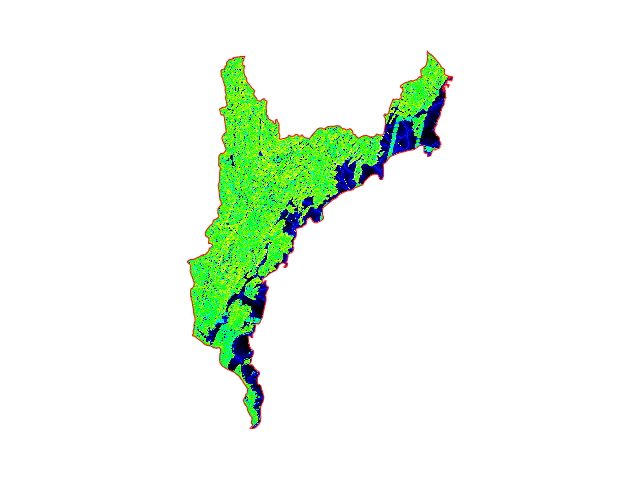

In [32]:
##print basins in grass @ Regional scale to confirm data and extent
gs.run_command('d.erase')
gs.parse_command('g.region',vector = 'tmp_bsn_buffer', align = dem)
gs.parse_command('r.mask',vector = 'tmp_bsn')
gs.run_command('d.rast', map= twi)
gs.run_command('d.vect', map= 'tmp_bsn',color='red',fill_color='None')
Image(filename="map.png")

In [33]:
gs.run_command('r.out.gdal', input= twi, output= raster_dir/f'{twi}.tif',createopt="BIGTIFF=YES,PROFILE=GeoTIFF,TFW=YES,COMPRESS=LZW",flags='f')

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File
</home/data/Rasters/new_rochelle_cva/twi_020301020203_b.tif> created.


0

## END